In [1]:
import numpy as np
import pandas as pd
from skbio.stats.composition import closure
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv, 
                                     inner, perturb_inv, clr, centralize,
                                     multiplicative_replacement, _gram_schmidt_basis)
from skbio import OrdinationResults, TreeNode, DistanceMatrix
from skbio.stats.ordination import pcoa
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova

import scipy
import ternary
import matplotlib.image as mpimg
from functools import partial
from scipy.optimize import minimize, fmin_bfgs, fmin_cg
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from gneiss.util import match

from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean, canberra, braycurtis, jaccard
from scipy.stats import linregress
from biom import load_table
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

Since the embad distance metric is fairly computationally expensive, we'll be using precomputed embad distance metrics.

In [3]:
soils_pcoa = OrdinationResults.read('../results/88soils_embad_pcoa.txt')
soils_mapping = pd.read_table('../data/88soils/103_prep_568_qiime_20150818-225427.txt', 
                              index_col=0)

#post_mortem_dm = pd.read_table('../results/dead_bodies_embad_dm.txt', index_col=0)
post_mortem_pcoa = OrdinationResults.read('../results/dead_bodies_embad_pcoa.txt')
post_mortem_mapping = pd.read_table('../data/post_mortem_mice/10141_prep_1265_qiime_20151201-205734.txt', 
                                    index_col=0)
#post_mortem_dm = DistanceMatrix(post_mortem_dm.values, ids=post_mortem_dm.index)
#post_mortem_pcoa = pcoa(post_mortem_dm)

In [4]:
soils_samples, soils_mapping = match(soils_pcoa.samples, soils_mapping)
pm_samples, pm_mapping = match(post_mortem_pcoa.samples, post_mortem_mapping)

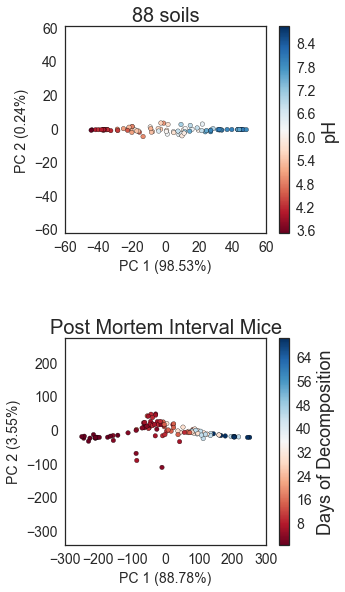

In [5]:
sns.set(font_scale=3)
sns.set_style("white")

fig = plt.figure(figsize=(5, 10))

gs = GridSpec(100, 100, bottom=0.18,left=0.18,right=0.88)

ax1 = fig.add_subplot(gs[:40, :])
ax2 = fig.add_subplot(gs[60:, :])

im = ax1.scatter(soils_samples[0], soils_samples[1], c=soils_mapping.ph, cmap=plt.cm.RdBu)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('pH', fontsize=18)
cbar.ax.tick_params(labelsize=14)        
ax1.tick_params(labelsize=14)
perc_explained = soils_pcoa.proportion_explained
ax1.set_xlabel('PC 1 ({:.2%})'.format(perc_explained[0]), fontsize=14)
ax1.set_ylabel('PC 2 ({:.2%})'.format(perc_explained[1]), fontsize=14)
ax1.axis('equal')
ax1.set_title('88 soils', fontsize=20)

im = ax2.scatter(pm_samples[0], pm_samples[1],
                 c=pm_mapping.harvest_time_days, cmap=plt.cm.RdBu)
perc_explained = post_mortem_pcoa.proportion_explained
ax2.tick_params(labelsize=14)
ax2.set_xlabel('PC 1 ({:.2%})'.format(perc_explained[0]), fontsize=14)
ax2.set_ylabel('PC 2 ({:.2%})'.format(perc_explained[1]), fontsize=14)
ax2.axis('equal')
ax2.set_title('Post Mortem Interval Mice', fontsize=20)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label('Days of Decomposition', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

fig.savefig('../results/embad.pdf')

In [6]:
soils_mapping['int_ph'] = soils_mapping.ph.astype(np.int)
soils_submapping = soils_mapping.loc[np.logical_or(soils_mapping.int_ph == 3, soils_mapping.int_ph == 8)]
soils_samples = soils_pcoa.samples.loc[soils_submapping.index]
soils_dm = DistanceMatrix.from_iterable(soils_samples.values, metric=euclidean)

In [7]:
permanova(soils_dm , soils_submapping.int_ph, permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      17
number of groups                  2
test statistic              650.526
p-value                      0.0003
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [8]:
post_mortem_submapping = post_mortem_mapping.loc[np.logical_or(post_mortem_mapping.harvest_time_days == 1, 
                                                               post_mortem_mapping.harvest_time_days == 71)]
post_mortem_samples, post_mortem_submapping = match(post_mortem_pcoa.samples, post_mortem_submapping)
post_mortem_dm = DistanceMatrix.from_iterable(post_mortem_samples.values, metric=euclidean)

In [9]:
permanova(post_mortem_dm , post_mortem_submapping.harvest_time_days, permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      23
number of groups                  2
test statistic              439.814
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [10]:
post_mortem_mapping.shape

(863, 67)

In [13]:
post_mortem_samples.shape

(23, 110)

In [14]:
post_mortem_submapping = post_mortem_mapping.loc[np.logical_or(post_mortem_mapping.harvest_time_days == 1, 
                                                               post_mortem_mapping.harvest_time_days == 71)]

In [15]:
post_mortem_submapping.shape

(166, 67)

In [18]:
len(set(post_mortem_pcoa.samples.index) & set(post_mortem_submapping.index))

23